In [7]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv('../.env')


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

model_name = os.getenv("OPENAI_MODEL_NAME")
_set_env("OPENAI_API_KEY")


from typing import Literal
# from langchain.chat_models import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

from langchain_openai import ChatOpenAI
# Initialize the language model using OpenAI's API.
model = ChatOpenAI(model_name=model_name, temperature=0.7)

import random
from typing import Annotated, Literal
from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState
def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

#########################################
# Define the Philosopher Agents
#########################################

# Socrates: His handoff tool sends control to Plato.
socrates_tools = [
    make_handoff_tool(agent_name="plato"),
]
socrates_agent = create_react_agent(
    model,
    socrates_tools,
    prompt=(
        "You are Socrates, the renowned philosopher known for your method of questioning. "
        "Engage in a deep, thoughtful discussion on the given topic. "
        "Ensure you include a clear, human-readable response before handing off control to Plato."
        "Make sure your response is very short."
    ),
)

def call_socrates(state: MessagesState) -> Command[Literal["plato", "human"]]:
    # Invoke Socrates' agent with the current message history.
    response = socrates_agent.invoke(state)
    # After Socrates answers, hand off to the human node.
    return Command(update=response, goto="human")


# Plato: His handoff tool sends control back to Socrates.
plato_tools = [
    make_handoff_tool(agent_name="socrates"),
]
plato_agent = create_react_agent(
    model,
    plato_tools,
    prompt=(
        "You are Plato, the influential philosopher and disciple of Socrates. "
        "Provide a reflective and reasoned analysis of the discussion topic. "
        "Ensure your response is human-readable before handing off control back to Socrates."
    ),
)

def call_plato(state: MessagesState) -> Command[Literal["socrates", "human"]]:
    response = plato_agent.invoke(state)
    return Command(update=response, goto="human")

#########################################
# Human Node: Collecting User Input
#########################################

def human_node(
    state: MessagesState, config
) -> Command[Literal["socrates", "plato", "human"]]:
    """
    This node collects user input and then routes the conversation back to
    the last active philosopher. It inspects the metadata (triggers) to determine
    which agent should receive the new input.
    """
    user_input = interrupt(value="Ready for user input.")
    langgraph_triggers = config["metadata"]["langgraph_triggers"]
    if len(langgraph_triggers) != 1:
        raise AssertionError("Expected exactly 1 trigger in human node")
    active_agent = langgraph_triggers[0].split(":")[1]
    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        goto=active_agent,
    )

#########################################
# Build the State Graph
#########################################

builder = StateGraph(MessagesState)
builder.add_node("socrates", call_socrates)
builder.add_node("plato", call_plato)
builder.add_node("human", human_node)

# Start the discussion with Socrates.
builder.add_edge(START, "socrates")

# Set up a memory checkpointer.
checkpointer = MemorySaver()

# Compile the graph.
graph = builder.compile(checkpointer=checkpointer)

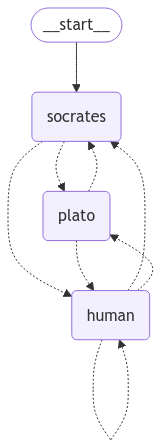

In [8]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import convert_to_messages

def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [10]:
import uuid
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

inputs = [
    # 1st round of conversation,
    {
        "messages": [
            {"role": "user", 
             "content": "Can you two, Socrates and Plato, discuss what the physical world is? Let's start with Socrates."},
        ]
    },
    # Since we're using `interrupt`, we'll need to resume using the Command primitive.
    # 2nd round of conversation,
    Command(
        resume="Plato, tell me what you think, based on what Socrates says."
    ),
    # # 3rd round of conversation,
    # Command(
    #     resume="i like the first one. could you recommend something to do near the hotel?"
    # ),
]
MAX_CNT = 30

for idx, user_input in enumerate(inputs):
    print()
    print(f"--- Conversation Turn {idx + 1} ---")
    print()
    print(f"User: {user_input}")
    print()
    for update in graph.stream(
        user_input,
        config=thread_config,
        stream_mode="updates",
    ):
        pretty_print_messages(update)
        counter = 0
        for node_id, value in update.items():
            if isinstance(value, dict) and value.get("messages", []):
                last_message = value["messages"][-1]
                if isinstance(last_message, dict) or last_message.type != "ai":
                    print(last_message)
                    continue
                print(f"{node_id}: {last_message.content}")
            print('node_id:', node_id, 'value:', value)

            counter += 1

        print('---',counter)
        if counter > MAX_CNT:
            break

        



--- Conversation Turn 1 ---

User: {'messages': [{'role': 'user', 'content': "Can you two, Socrates and Plato, discuss what the physical world is? Let's start with Socrates."}]}

Update from node socrates:


================================ Human Message =================================

Can you two, Socrates and Plato, discuss what the physical world is? Let's start with Socrates.
================================== Ai Message ==================================

The physical world, dear interlocutor, invites us to explore the nature of reality. What do we consider "physical"? Is it merely what we can touch and see, or is it something deeper? If we assert that the physical world is all that exists, can we then disregard the realm of ideas and forms, which appear to shape our understanding of that very world? Would it not be prudent to question whether the essence of things transcends their physical manifestations? 

Now, I pass the discussion to you, Plato.


socrates: The physical wo

TypeError: tuple indices must be integers or slices, not str

In [4]:
counter

1